# Exercice

L'objectif est de prendre un main un code qui permet d'entrainer un CNN. Nous utiliserons Python et quelques libraries pour la mise en forme.

# Installation des librairies

Il s'agit de librairies qui seront utilisées pour manipuler les images et le réseau de neurone. Il contient une fonction pour simplement rendre quelques images visibles à titre d'illustration.

In [90]:
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import random
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score
import os
!pip install livelossplot
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential # Model type to be used
from tensorflow.keras.layers import Dense, Activation, Dropout# Make Fully connected (FC) layers
import numpy as np

# Visualisation display

def show_sample(X_train, Y_train):
  plt.figure(figsize=(5,5))
  plt.subplot(1,4,1)
  index = random.randint(0, X_train.shape[0])
  plt.title(Y_train[index])
  plt.imshow(X_train[index])
  plt.subplot(1,4,2)
  index = random.randint(0, X_train.shape[0])
  plt.title(Y_train[index])
  plt.imshow(X_train[index])
  plt.subplot(1,4,3)
  index = random.randint(0, X_train.shape[0])
  plt.title(Y_train[index])
  plt.imshow(X_train[index])
  plt.subplot(1,4,4)
  index = random.randint(0, X_train.shape[0])
  plt.title(Y_train[index])
  plt.imshow(X_train[index])

def show_fx_negatif(X_test, Y_pred, Y_test, dico_y):

  Y_pred_classes = np.argmax(Y_pred, axis=1)
  Y_true_classes = np.argmax(Y_test, axis=1)

  FX_NEGATIF = X_test[(Y_pred_classes!=Y_true_classes)]
  Pred_fx_negatif = Y_pred_classes[(Y_pred_classes!=Y_true_classes)]
  GT_fx_negatif = Y_true_classes[(Y_pred_classes!=Y_true_classes)]

  fig, axs = plt.subplots(1, 5, constrained_layout=True)
  for p in range(0,5):
    i = random.randint(0, len(FX_NEGATIF)-1)
    axs[p].imshow(FX_NEGATIF[i])
    axs[p].set_title('GT '+str(dico_y[GT_fx_negatif[i]])+'\n Pred '+str(dico_y[Pred_fx_negatif[i]]))

  fig.suptitle("Mauvais classement", y=0.7, fontsize=16)  # Réduit l'espace entre le titre principal et les graphiques

  plt.show()


def show_true_positif(X_test, Y_pred, Y_test, dico_y):

  Y_pred_classes = np.argmax(Y_pred, axis=1)
  Y_true_classes = np.argmax(Y_test, axis=1)
  TR_POSITIF = X_test[(Y_pred_classes==Y_true_classes)]
  Pred_tx_positif = Y_pred_classes[(Y_pred_classes==Y_true_classes)]
  GT_tx_positif = Y_true_classes[(Y_pred_classes==Y_true_classes)]

  fig, axs = plt.subplots(1, 5, constrained_layout=True)
  for p in range(0,5):
    i = random.randint(0, len(TR_POSITIF)-1)
    axs[p].imshow(TR_POSITIF[i])
    axs[p].set_title('GT '+str(dico_y[GT_tx_positif[i]])+'\n Pred '+str(dico_y[Pred_tx_positif[i]]))

  fig.suptitle("Bon classement", y=0.7, fontsize=16)  # Réduit l'espace entre le titre principal et les graphiques

  plt.show()


def accuracy_per_class(Y_true, Y_pred):
  Y_pred_classes = np.argmax(Y_pred, axis=1)
  Y_true_classes = np.argmax(Y_true, axis=1)

  unique_classes = np.unique(Y_true_classes)
  class_counts = {}

  for cls in unique_classes:
      class_counts[cls] = {
          'correct': np.sum((Y_true_classes == cls) & (Y_pred_classes == cls)),
          'incorrect': np.sum((Y_true_classes == cls) & (Y_pred_classes != cls))
      }

  #Prepare the data for the bar chart
  classes = list(class_counts.keys())
  correct_predictions = [class_counts[cls]['correct'] for cls in classes]
  incorrect_predictions = [class_counts[cls]['incorrect'] for cls in classes]

  #Create the bar chart
  x = np.arange(len(classes))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, correct_predictions, width, label='Correct Predictions')
  rects2 = ax.bar(x + width/2, incorrect_predictions, width, label='Incorrect Predictions')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Number of Predictions')
  ax.set_title('Prediction Accuracy per Class')
  ax.set_xticks(x)
  ax.set_xticklabels(classes)
  ax.legend()


  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')


  autolabel(rects1)
  autolabel(rects2)

  fig.tight_layout()

  plt.show()

from skimage.io import imread
from tqdm import tqdm
def get_data(train_df,IMAGE_SIZE):
  IMG = [] # np.zeros((len(train_df['Label']),IMAGE_SIZE[0],IMAGE_SIZE[1],3),dtype='uint8')
  LAB = []
  i=0
  for ix,iy in tqdm(zip(train_df['Filepath'], train_df['Label']),total=len(train_df['Label'])):
    img = imread(ix)
    # if img.ndim == 2:
    #   img = np.stack((img,)*3, axis=-1)
    if img.ndim == 3:
      rez = tf.image.resize(img, IMAGE_SIZE).numpy()
      rez = rez[:,:,:3].astype('uint8')
      # IMG[i,:,:,:] = rez[:,:,:3]
      IMG.append(rez[:,:,:3])
      LAB.append(iy)
      # i+=1
  IMG = np.array(IMG)
  return IMG,LAB
def multiclass_encoding(LAB):
  I = np.unique(LAB)
  dico_label = {}
  dico_y = {}
  for i in range(len(I)):
    dico_label[I[i]] = i
    dico_y[i] = I[i]
  return dico_label,dico_y

# Importation des données

**I -Importation et visualisation des données**

Nous utiliserons les données Reptiles pour la prise en main de ce code. Cette base de données contient des images de reptiles.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vencerlanz09/reptiles-and-amphibians-image-dataset")

print("Path to dataset files:", path)

100%|██████████| 135M/135M [00:02<00:00, 61.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vencerlanz09/reptiles-and-amphibians-image-dataset/versions/2


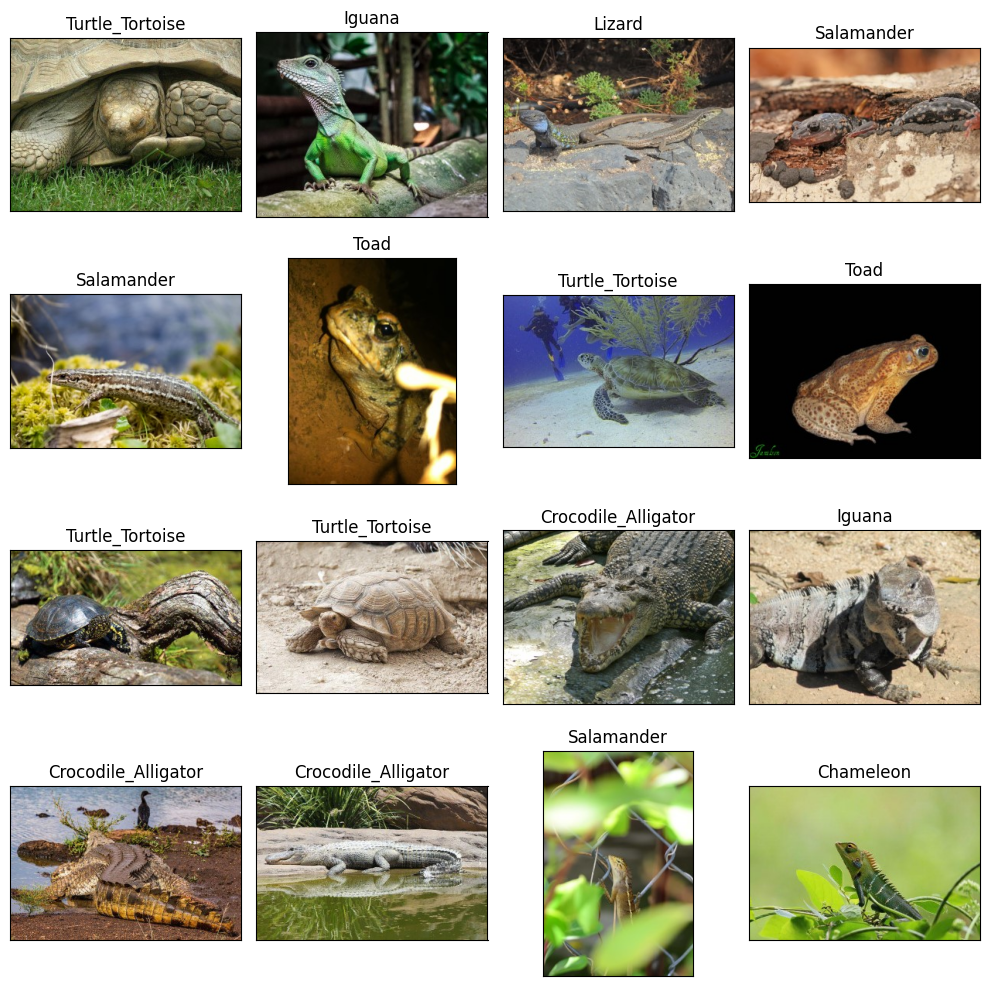

In [3]:
from pathlib import Path
import os.path
import pandas as pd
image_dir = Path(path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Constituer une base de données train, validation, test

**II - Division de la base de données en train, validation et test**


In [76]:
from sklearn.model_selection import train_test_split

IMAGE_SIZE = (128, 128)

TRAIN_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)
train_df, val_df = train_test_split(TRAIN_df, test_size=0.2, shuffle=True, random_state=42)

x_train, train_Label = get_data(train_df,IMAGE_SIZE)
x_val, val_Label = get_data(val_df,IMAGE_SIZE)
x_test, test_Label = get_data(test_df,IMAGE_SIZE)

dico_label,dico_y = multiclass_encoding(train_Label)
train_chiffre = [dico_label[ix] for ix in train_Label]
val_chiffre = [dico_label[ix] for ix in val_Label]
test_chiffre = [dico_label[ix] for ix in test_Label]

Y_train = to_categorical(train_chiffre)
Y_val = to_categorical(val_chiffre)
Y_test = to_categorical(test_chiffre)

print('Reptile Dataset Shape (images, hauteur, largeur):')
print("Shape of X_train:", x_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_val:", x_val.shape)
print("Shape of Y_val:", Y_val.shape)
print("Shape of X_test:", x_test.shape)
print("Shape of Y_test:", Y_test.shape)

100%|██████████| 1209/1209 [00:03<00:00, 336.91it/s]

Reptile Dataset Shape (images, hauteur, largeur):
Shape of X_train: (3868, 128, 128, 3)
Shape of Y_train: (3868, 10)
Shape of X_val: (966, 128, 128, 3)
Shape of Y_val: (966, 10)
Shape of X_test: (1209, 128, 128, 3)
Shape of Y_test: (1209, 10)


**III - Pré-traitement des données**


Mise en forme des variables pour qu'elles correspondent aux entrées du réseau de neurone.

In [77]:
# Ajout d'un canneau supplémentaire
# Type de la données : float32
# Normalisation des données pour des pixels entre 0 et 1
# Input for model in exercice 1
X_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2]*x_train.shape[3]).astype('float32') #add an additional dimension to represent the single-channel
X_val = x_val.reshape(x_val.shape[0], x_val.shape[1]*x_val.shape[2]*x_val.shape[3]).astype('float32') #add an additional dimension to represent the single-channel
X_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2]*x_test.shape[3]).astype('float32')

X_train /= 255 # normalize each value for each pixel for the entire vector for each input
X_val /= 255 # normalize each value for each pixel for the entire vector for each input
X_test /= 255  # normalize each value for each pixel for the entire vector for each input

print("Training matrix shape", X_train.shape,Y_train.shape)
print("Validation matrix shape", X_val.shape,Y_val.shape)
print("Testing matrix shape", X_test.shape,Y_test.shape)

Training matrix shape (3868, 49152) (3868, 10)
Testing matrix shape (1209, 49152) (1209, 10)


# Modèle CNN

**IV - Définition du modèle**


In [94]:
# CN neural network
model = Sequential([
    Dense(Y_train.shape[1],input_shape=(X_train.shape[1],)), # It is the output layer and should be equal to the number of desired classes (10 in this case).
    Activation('softmax'),
])

# # Including Dropout to reduce overfitting
# Pkeep=0.25
# model = Sequential([
#     Dense(1000, input_shape=(X_train.shape[1],)),
#     Activation('relu'),
#     Dropout(Pkeep),
#     Dense(100, input_shape=(1000,)),
#     Activation('relu'),
#     Dropout(Pkeep),
#     Dense(60, input_shape=(100,)),
#     Activation('relu'),
#     Dropout(Pkeep),
#     Dense(30, input_shape=(60,)),
#     Activation('relu'),
#     Dropout(Pkeep),
#     Dense(Y_train.shape[1]),
#     Activation('softmax'),
# ])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 10)                  │         491,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_26 (Activation)           │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 491,530 (1.88 MB)

 Trainable params: 491,530 (1.88 MB)

 Non-trainable params: 0 (0.00 B)

**V-a) Hyperparamètres du modèle et de l'entrainement**

Définition des hyperparamètres pour l'apprentissage :

1ère groupe:

- Algorithme d'optimisation
- Fonction de perte (dans le cas d'une classification)
- Métrique (dans le cas d'une classification)

In [95]:
learning_rate = 0.0001 #@param {type:"number"}
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Use the specified learning rate
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

2eme groupe:
- EarlyStopping
- Sauvegarde du meilleur modèle

In [96]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, verbose=1, mode='auto') #Stop training when a monitored metric has stopped improving.

checkpoint_filepath = '/content/best_ex1.keras'
Model_check = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='auto') #Callback to save the Keras model or model weights at some frequency.

3e groupe:
- Nombre de batch
- Nombre d'epoch
- Validation split
- Verbose : variable booleenne pour l'affichage de la progression de l'entrainement

Lorsque les hyperparamètres d'apprentissage et de l'architecture sont fixées, l'entrainement peut être lancé.

**V- b) Entrainement du modèle et évaluation du modèle sur les données de validation**

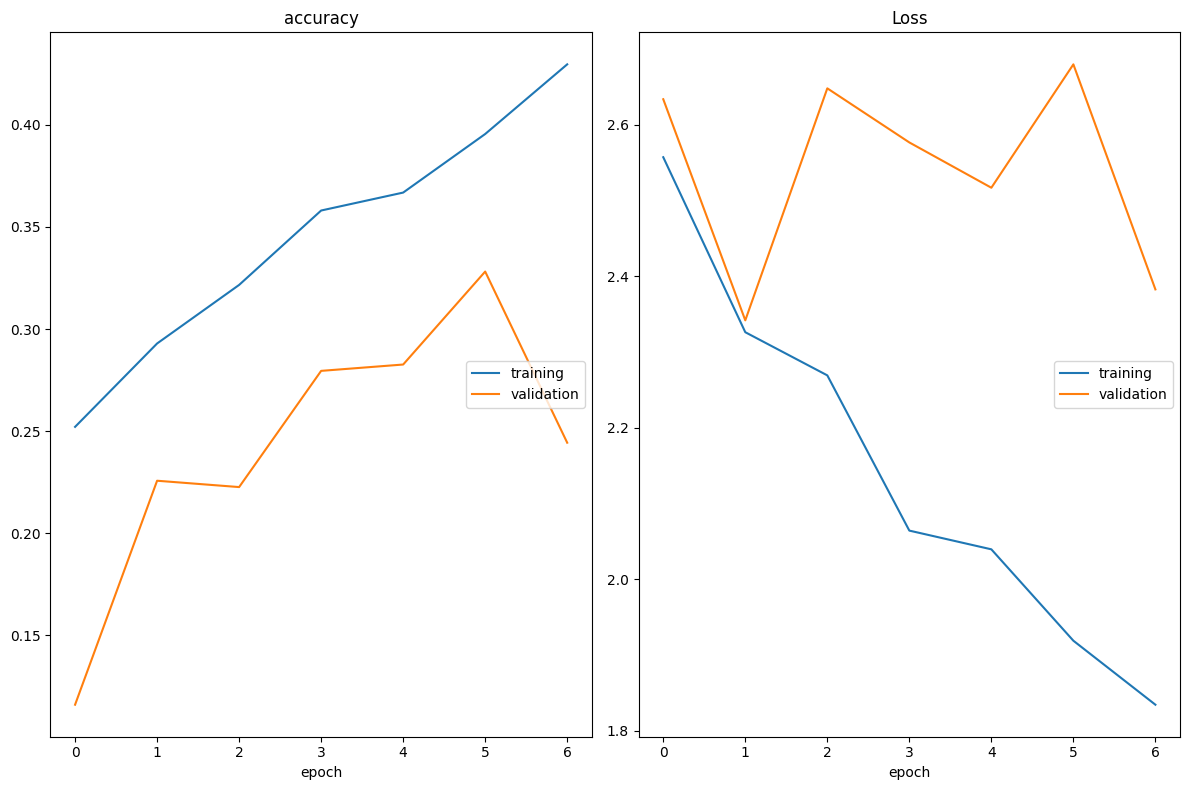

accuracy
	training         	 (min:    0.252, max:    0.430, cur:    0.430)
	validation       	 (min:    0.116, max:    0.328, cur:    0.244)
Loss
	training         	 (min:    1.834, max:    2.557, cur:    1.834)
	validation       	 (min:    2.342, max:    2.680, cur:    2.383)

Epoch 7: val_loss did not improve from 2.34168
553/553 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4477 - loss: 1.7698 - val_accuracy: 0.2443 - val_loss: 2.3826
Epoch 7: early stopping


In [97]:
# Fiting the model
from livelossplot import PlotLossesKeras
plotlossesdeeper = PlotLossesKeras()
results = model.fit(X_train, Y_train,validation_data=(X_val,Y_val),
                    batch_size=7, epochs=10,
                    verbose=1,
                    callbacks=[plotlossesdeeper,early_stop,Model_check])

## Evaluation

In [98]:
model = tf.keras.models.load_model('/content/best_ex1.keras') #Loading the best model

In [99]:
res_ = model.evaluate(X_test,Y_test,return_dict=True) #Evaluation of the model on the test dataset
print(res_)

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2404 - loss: 2.2975
{'accuracy': 0.2406947910785675, 'loss': 2.3313705921173096}


# Inférence

In [100]:
Y_pred = model.predict(X_test) # Prediction of classes

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [101]:
# Convert probabilities to class labels
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Calculate precision and recall
precision = precision_score(Y_true_classes, Y_pred_classes, average='macro')
recall = recall_score(Y_true_classes, Y_pred_classes, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

Precision: 0.18222473798131694
Recall: 0.16041420929109979


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


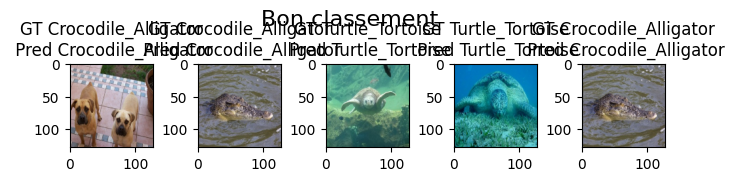

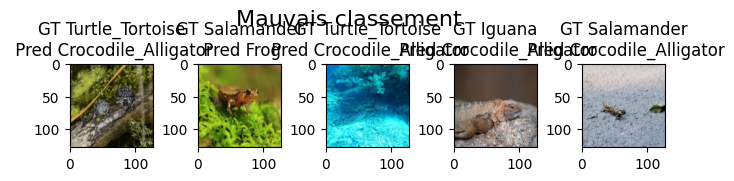

In [102]:
show_true_positif(x_test, Y_pred, Y_test, dico_y)
show_fx_negatif(x_test, Y_pred, Y_test, dico_y)

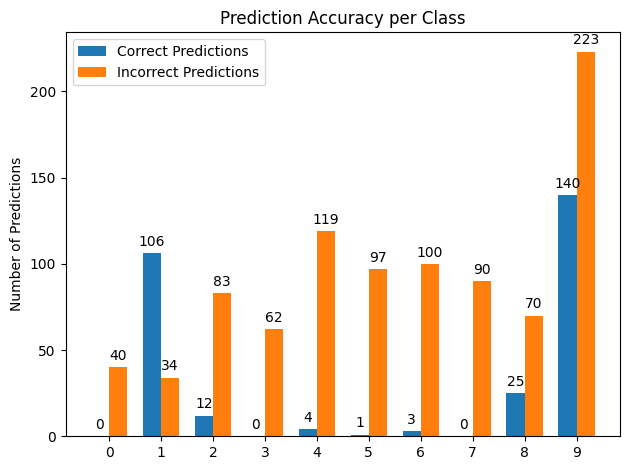

In [103]:
accuracy_per_class(Y_test, Y_pred)